In [1]:
import requests
import networkx as nx
import numpy as np
import math
import random

from copy import deepcopy

import matplotlib.pyplot as plt
import matplotlib
import plotly.graph_objs as go

%matplotlib inline

In [2]:
id = 63399107
access_token = 'ba750c0fba750c0fba750c0ff2ba1f5397bba75ba750c0fe6b885ae3f36b2fe81010b1d'

In [3]:
res_users = requests.get('https://api.vk.com/method/users.get?user_ids={0}&access_token={1}&v=5.95'.format(id, access_token))
my_id = res_users.json()['response'][0]['id']

In [4]:
def ids_friends(user_ids):
    friends_url = 'https://api.vk.com/method/friends.get?user_id={}&access_token={}&v=5.95'
    json_response = requests.get(friends_url.format(user_ids, access_token)).json()
    if json_response.get('Error'):
        print(json_response.get('Error'))
        return list()
    return json_response

In [5]:
friend_ids = ids_friends(id)
friend_ids['response']['items'][0]

friends_of_friend = ids_friends(friend_ids['response']['items'][0])
friends_of_friend['response']['items'][0]

239993

In [6]:
graph = {}

friends = ids_friends(my_id)['response']['items']
graph[my_id] = friends

for f in friends:
    friends_of_friend = ids_friends(f)
    if 'response' in friends_of_friend:
        
        graph[f] = friends_of_friend['response']['items']



In [7]:
team = [63399107, 32703581, 86991442]

In [8]:
friends_of_team = set()
for member in team:
    friends_of_team.add(member)
    for person in graph[member]:
        friends_of_team.add(person)

In [9]:
graph_final = {}
for person in graph:
    cur_friends = graph[person]
    new_friends = []
    for item in cur_friends:
        if item in friends_of_team:
            new_friends.append(item)
    graph_final[person] = new_friends

In [10]:
graph_finfin = {}
for person in friends_of_team:
    if person in graph_final.keys():
        graph_finfin[person] = graph_final[person]
    else:
        tmp = []
        for item in graph_final:
            if person in graph_final[item]:
                tmp.append(item)
        graph_finfin[person] = tmp

In [11]:
def make_nx_graph(graph):
    g = nx.Graph()
    for i in graph:
        for j in graph[i]:
            if not (g.has_edge(j, i) or g.has_edge(i, j)):
                g.add_edge(i, j)
    return g

In [12]:
graph_nx = make_nx_graph(graph_finfin)

In [13]:
common = []
cnt = 0
for item in graph_finfin:
    count = 0
    for member in team:
        if member in graph_finfin[item]:
            count += 1
    if count == 3:
        common.append(item)
        cnt += 1

In [14]:
common = common[0:12]

In [55]:
lonely = {}
for member in team:
    stop_set = set(team + common)
    stop_set.remove(member)
    lonely[member] = []
    for item in graph_finfin:
        if member in graph_finfin[item]:
            if (len(set(graph_finfin[item]).intersection(stop_set)) == 0):
                lonely[member].append(item)

In [56]:
for item in lonely:
    lonely[item] = lonely[item][16:21]

In [57]:
lonely

{63399107: [24099121, 308070708, 304374148, 66642316, 265339304],
 32703581: [53012650, 8294581, 168073398, 68229314, 72687841],
 86991442: [3180608, 64516164, 6228048, 34916432, 4423773]}

In [58]:
guests = team + common
for item in lonely:
    guests += lonely[item]

In [59]:
graph_guests = {}
for item in graph_finfin:
    if item in guests:
        graph_guests[item] = []
        for friend in graph_finfin[item]:
            if friend in guests:
                graph_guests[item].append(friend)

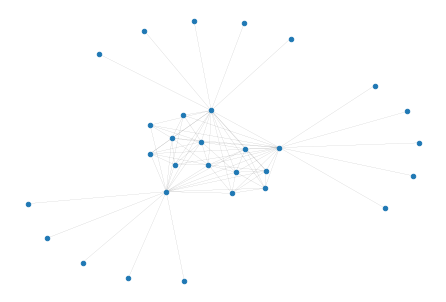

In [60]:
nx.draw_spring(make_nx_graph(graph_guests), node_size=20, width=0.055)

In [61]:
def about_friends(user_ids):
    friends_url = 'https://api.vk.com/method/users.get?user_id={}&access_token={}&fields=first_name&v=5.95'
    json_response = requests.get(friends_url.format(user_ids, access_token)).json()
    if json_response.get('Error'):
        print(json_response.get('Error'))
        return list()
    return json_response

In [62]:
def name_surname(id):
    info = about_friends(id)['response'][0]
    return info['first_name'] + ' ' + info['last_name']

In [63]:
dict_names = {}
for friend in team:
    dict_names[friend] = name_surname(friend)
    for item in graph[friend]:
        dict_names[item] = name_surname(item)

In [64]:
graph_names = {}

for friend in guests:
    graph_names[dict_names[friend]] = []
    try:
        for item in graph_guests[friend]:
            if item in guests:
                graph_names[dict_names[friend]].append(dict_names[item])
    except:
        continue

In [65]:
def path(friend1, friend2):
    return nx.shortest_path(make_nx_graph(graph_names), friend1, friend2)

In [69]:
path("Olesya Kovaleva", "Ekaterina Osipova")

['Olesya Kovaleva',
 'Natalya Bernshteyn',
 'Darya Obrezkova',
 'Ekaterina Osipova']

In [68]:
from py2neo import Graph, Node, Relationship
g = Graph("bolt://localhost:7687")
for friend in graph_names:
    a = Node("Person", name=friend)
    for item in graph_names[friend]:
        b = Node("Person", name=item)
        KNOWS = Relationship.type("FRIEND_OF")
        g.merge(KNOWS(a, b), "Person", "name")